In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
#import libraries 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:

# 1.Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
num_epochs = 3
learning_rate = 1e-3
num_classes = 10
save_dir = "./results"
os.makedirs(save_dir, exist_ok=True)

In [3]:
#from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# Training transformations: resize, data augmentation, tensor conversion, normalization
transform_train = transforms.Compose([
    transforms.Resize(224), #Resize to 224x224 for pretrained CNNs as models were trained for the same
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

In [4]:

# 3. Create partial training set

fraction = 0.1 #using only 0.1 of dataset 
num_train_samples = int(len(train_dataset) * fraction)

np.random.seed(42)  # for reproducibility, everytime  u run the code u get same random datasets
subset_indices = np.random.choice(len(train_dataset), num_train_samples, replace=False)#its a array containing indices of images randomly
train_subset = Subset(train_dataset, subset_indices)#subset is utility in pytorch , that takes data, indices and makes a subset of it

In [5]:
# 4. DataLoaders
batch_size = 64 # 5000/128 = 78 batches per epoch (0.1 of 50000)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training on {len(train_subset)} samples, Testing on {len(test_dataset)} samples")

Training on 5000 samples, Testing on 10000 samples


In [6]:
# 3. Models

import timm # For pretrained models not in torchvision (e.g., Xception)
from torch import nn

def get_model(name, num_classes=10, pretrained=True, device=None):
    if name == "resnet18":
        from torchvision import models
        weights = models.ResNet18_Weights.DEFAULT if pretrained else None # Load pretrained weights if requested
        model = models.resnet18(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, num_classes)# Replace final fully connected layer to match CIFAR-10 classes

    elif name == "densenet121":
        from torchvision import models
        weights = models.DenseNet121_Weights.DEFAULT if pretrained else None #same as above 
        model = models.densenet121(weights=weights)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes) #same as above 

    elif name == "xception65" :
        model = timm.create_model("xception", pretrained=pretrained, num_classes=num_classes) #loading model using timm library 

    else:
        raise ValueError(f"Unsupported model name: {name}")

    if device:
        model = model.to(device)
    return model

model_names = ["resnet18", "xception65", "densenet121"]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def train_model(model, train_loader, test_loader, num_epochs, lr, model_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    torch.save(model.state_dict(), f"{save_dir}/{model_name}.pth")

    # Evaluate on test set
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels_np = np.array(all_labels)
    all_preds_np = np.array(all_preds)
    all_probs_np = np.array(all_probs)

    # Compute metrics
    acc = accuracy_score(all_labels_np, all_preds_np)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels_np, all_preds_np, average='weighted', zero_division=0)
    cm = confusion_matrix(all_labels_np, all_preds_np)

    # ROC-AUC (multi-class)
    try:
        roc_auc = roc_auc_score(all_labels_np, all_probs_np, multi_class='ovr')
    except ValueError:
        roc_auc = None

    # Plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} — Confusion Matrix")
    plt.show()

    print(f"{model_name} - Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc}")

    return {
        "model": model,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": cm,
        "train_losses": train_losses
    }



Training resnet18...
Epoch [1/3], Loss: 0.9699
Epoch [2/3], Loss: 0.6210
Epoch [3/3], Loss: 0.4751


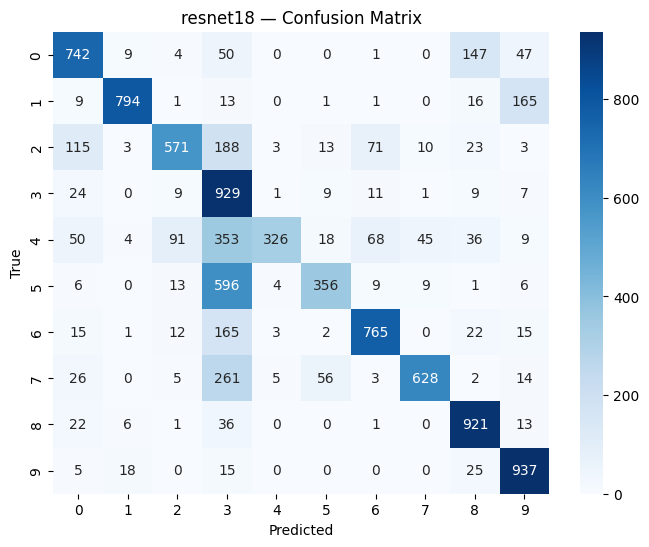

resnet18 - Accuracy: 0.6969, Precision: 0.7848, Recall: 0.6969, F1: 0.6978, ROC-AUC: 0.9700657333333333

Training xception65...


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Epoch [1/3], Loss: 0.6780
Epoch [2/3], Loss: 0.3309
Epoch [3/3], Loss: 0.2519


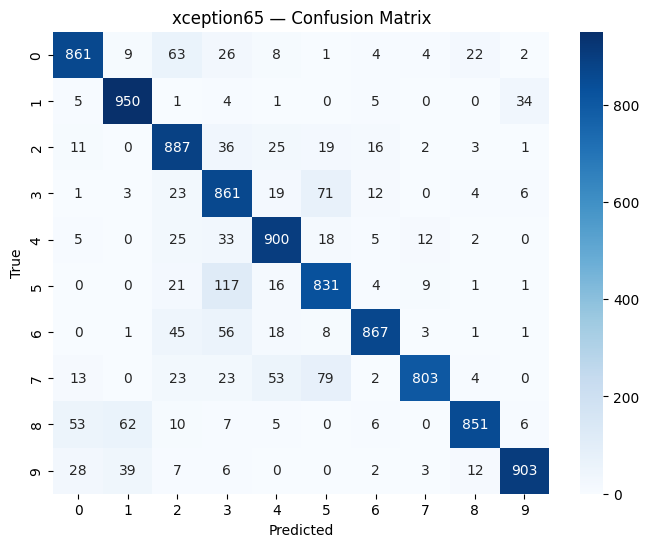

xception65 - Accuracy: 0.8714, Precision: 0.8776, Recall: 0.8714, F1: 0.8725, ROC-AUC: 0.9905508388888891

Training densenet121...
Epoch [1/3], Loss: 0.9428
Epoch [2/3], Loss: 0.5886
Epoch [3/3], Loss: 0.4533


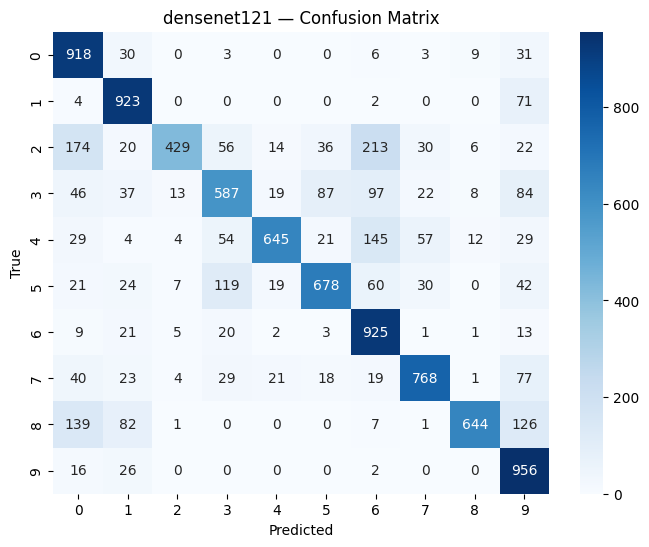

densenet121 - Accuracy: 0.7473, Precision: 0.7809, Recall: 0.7473, F1: 0.7407, ROC-AUC: 0.9733215166666668


In [15]:
model_names = ["resnet18", "xception65", "densenet121"]
results = {}

for name in model_names:
    print(f"\nTraining {name}...")
    model = get_model(name, device=device)
    results[name] = train_model(model, train_loader, test_loader, num_epochs, learning_rate, name)
